# SOPRANO: a Python library for generation, manipulation and analysis of large batches of crystalline structures
by Simone Sturniolo

```
      _
    /|_|\   
   / / \ \  
  /_/   \_\  
  \ \   / /  
   \ \_/ /  
    \|_|/  

```
    
Developed within the CCP-NC project. Copyright STFC 2016


### TUTORIAL 5 - NMR Properties: using Soprano for working with .magres files

In [1]:
# Basic imports
import os, sys
sys.path.insert(0, os.path.abspath('..')) # This to add the Soprano path to the PYTHONPATH
                                          # so we can load it without installing it

In [2]:
# Other useful imports

import numpy as np

import ase
from ase import io as ase_io

%matplotlib notebook
import matplotlib.pyplot as plt

## 1 - LOADING MAGRES FILES

ASE now is compatible with the Magres file format as well. If your version of ASE does not support loading
Magres files, try updating it or download the bleeding edge version from GitLab:

https://gitlab.com/ase/ase

In [3]:
C2H5O = ase_io.read('tutorial_data/ethanol.magres')

## 2 - LABELS AND INDICES

Labels and indices used in the magres file are stored in their own arrays and can be easily accessed and used to 
select atoms.

In [4]:
labels = C2H5O.get_array('labels')
indices = C2H5O.get_array('indices')

# Select only the protons' indices
H_i = np.where(labels == 'H')
H = C2H5O[H_i]
# Select only C2
C2_i = np.where((labels == 'C') & (indices == 2))
C2 = C2H5O[C2_i]

print "There are {0} hydrogen atoms".format(len(H))
print "The C2 atom is positioned at x = {0}, y = {1}, z = {2} Ang".format(*C2.get_positions()[0])

There are 6 hydrogen atoms
The C2 atom is positioned at x = -0.247915, y = 1.164107, z = 0.937396 Ang


In [5]:
# One can also recreate the Jmol-style labels if needed
jmol_labels = ["{0}_{1}".format(l, i) for l, i in zip(labels, indices)]
print "The labels are {0}".format(', '.join(jmol_labels))

The labels are H_1, H_2, H_3, H_4, H_5, H_6, C_1, C_2, O_1


## 3 - MAGNETIC SHIELDINGS AND CHEMICAL SHIFTS

All the NMR tensors stored in the original .magres file are saved as arrays in the Atoms object and can be accessed directly. However, Soprano also provides a set of properties to express the tensors in the form of parameters useful to compute the spectrum.

In [6]:
from soprano.properties.nmr import *

# Isotropy, Anisotropy and Asymmetry (Haeberlen convention)
iso = MSIsotropy.get(C2H5O)
aniso = MSAnisotropy.get(C2H5O)
asymm = MSAsymmetry.get(C2H5O)

print 'Label\tIsotropy\tAnisotropy\tAsymmetry'
for i, jl in enumerate(jmol_labels):
    print '{0}\t{1:.2f} ppm\t{2:.2f} ppm\t{3:.2f}'.format(jl, iso[i], aniso[i], asymm[i])

Label	Isotropy	Anisotropy	Asymmetry
H_1	29.59 ppm	8.94 ppm	0.14
H_2	30.26 ppm	8.19 ppm	0.21
H_3	30.10 ppm	7.29 ppm	0.06
H_4	26.98 ppm	8.17 ppm	0.94
H_5	27.39 ppm	-7.12 ppm	0.93
H_6	31.98 ppm	14.12 ppm	0.45
C_1	156.47 ppm	33.80 ppm	0.70
C_2	109.86 ppm	70.25 ppm	0.41
O_1	268.03 ppm	-51.38 ppm	0.98


In [7]:
# Span and skew
span = MSSpan.get(C2H5O)
skew = MSSkew.get(C2H5O)

print 'Label\tSpan\t\tSkew'
for i, jl in enumerate(jmol_labels):
    print '{0}\t{1:.2f} ppm\t{2:.2f}'.format(jl, span[i], skew[i])

Label	Span		Skew
H_1	9.36 ppm	-0.82
H_2	8.76 ppm	-0.74
H_3	7.43 ppm	-0.92
H_4	10.72 ppm	-0.05
H_5	9.33 ppm	0.05
H_6	16.25 ppm	-0.48
C_1	41.73 ppm	-0.24
C_2	79.95 ppm	-0.51
O_1	68.22 ppm	0.01


In [8]:
# Quaternion (orientation of the tensor with respect to the Cartesian axes)
# from which we extract the Euler angles

quat = MSQuaternion.get(C2H5O)

print 'Label\talpha\tbeta\tgamma'
for i, jl in enumerate(jmol_labels):
    a, b, c = quat[i].euler_angles(mode='zyz')*180/np.pi # rad to degrees
    print '{0}\t{1:.2f}\t{2:.2f}\t{3:.2f}'.format(jl, a, b, c)

Label	alpha	beta	gamma
H_1	26.84	134.66	-27.96
H_2	86.77	77.37	-92.66
H_3	-13.54	144.86	177.96
H_4	-64.85	96.81	177.34
H_5	-134.91	116.78	53.84
H_6	25.35	137.71	60.93
C_1	-27.03	132.57	-93.10
C_2	-138.63	125.07	-9.26
O_1	-125.99	120.41	66.77


## 4 - ELECTRIC FIELD GRADIENTS AND QUADRUPOLAR COUPLINGS

Similarly named properties exist for the EFG tensors - EFGSpan, EFGAnisotropy, EFGQuaternion, etc. A few more are specific (and of course there's no EFGIsotropy, for obvious reasons).
The most important difference is of course the introduction of the quadrupolar constant $\chi$, namely:

$\chi = \frac{e^2qQ}{h}$

where $e$ is the elementary charge, $V_{zz}=eq$, $Q$ is the quadrupole moment of the given element and isotope and $h$ the Planck constant. This definition returns a frequency. If one wants a pulsation $\omega$ it needs to multiplied by a factor of $2\pi$.

In [9]:
# Vzz component, in atomic units

vzz = EFGVzz.get(C2H5O)

# For quadrupolar constants, isotopes become relevant. This means we need to create custom Property instances to
# specify them. There are multiple ways to do so - check the docstrings for more details - but here we set them
# by element. When nothing is specified it defaults to the most common NMR active isotope.

qP = EFGQuadrupolarConstant(isotopes={'H': 2}) # Deuterated; for the others use the default
qC = qP(C2H5O)/1e6 # To MHz

print 'Label\tVzz\t\tChi'
for i, jl in enumerate(jmol_labels):
    print '{0}\t{1:5.2f} au\t{2:5.2f} MHz'.format(jl, vzz[i], qC[i])

Label	Vzz		Chi
H_1	 0.29 au	 0.19 MHz
H_2	 0.28 au	 0.19 MHz
H_3	 0.29 au	 0.20 MHz
H_4	 0.27 au	 0.18 MHz
H_5	 0.28 au	 0.19 MHz
H_6	 0.44 au	 0.30 MHz
C_1	 0.04 au	 0.00 MHz
C_2	 0.40 au	 0.00 MHz
O_1	-1.86 au	11.19 MHz


# 5 - CREATING SIMPLE SPECTRA

Besides handling NMR properties, Soprano also allows to create simple simulations of NMR spectra. These are only computed by considering the known properties of shielding and quadrupolar interactions, which means that their accuracy is limited; they are *not* spin dynamics simulations and should be treated as such. Currently these include orientational as well as isotropic effects, up to the second order for quadrupole interactions. The limit of infinite speed MAS is included as well. They do NOT include:

* dipolar interactions
* J-couplings
* finite spinning speed effects
* cross-polarisation or other pulse sequence effects

In [10]:
# Let's look at the ethanol molecule. First we create an NMR calculator

from soprano.calculate.nmr.nmr import NMRCalculator, NMRFlags

nCalc = NMRCalculator(C2H5O) # We create the calculator here

# Setting the Larmor frequency; default units are MHz
# This is set for a specific isotope and determines the magnetic field for everything else as well
nCalc.set_larmor_frequency(42.6, element='1H')
print "Field: {0:.2f} T".format(nCalc.B)
# We can also get what the frequency would be for a different element...
print "Larmor frequency for 13C: {0:.2f} MHz".format(nCalc.get_larmor_frequency('13C'))

# Set a reference shielding, in ppm
nCalc.set_reference(100, '1H')

# Set a powder averaging. Higher values of N mean finer average
nCalc.set_powder(N=16)
print "Powder orientations: {0}".format(len(nCalc._orients[0]))

Field: 1.00 T
Larmor frequency for 13C: 10.71 MHz
Powder orientations: 545


In [11]:
# Compute the spectrum for protons; only chemical shielding, including anisotropy effects
freqRange = 100
spec1H_aniso, freqs = nCalc.spectrum_1d('1H', effects=NMRFlags.STATIC, max_freq=freqRange, min_freq=0, bins=501)
# Now only the isotropic lines (as if spinning)
# We add a broadening to make the lines more visible
spec1H_iso, freqs = nCalc.spectrum_1d('1H', effects=NMRFlags.MAS, max_freq=freqRange, min_freq=0, bins=501,
                                      freq_broad=0.2)

<IPython.core.display.Javascript object>


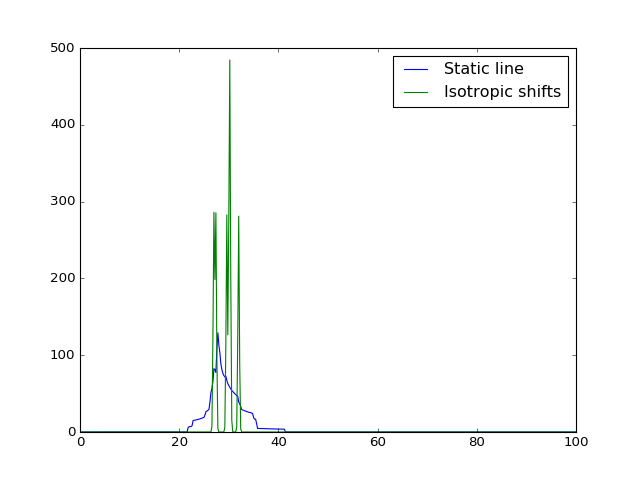

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(freqs, spec1H_aniso, label='Static line')
ax.plot(freqs, spec1H_iso, label='Isotropic shifts')

ax.legend()

In [13]:
# Now let's look at the static quadrupolar line of 17O
freqRange = 1000000
spec17O_1, freqs = nCalc.spectrum_1d('17O', effects=NMRFlags.Q_1_ORIENT, max_freq=freqRange, min_freq=-freqRange, bins=501)
spec17O_s, freqs = nCalc.spectrum_1d('17O', effects=NMRFlags.Q_STATIC, max_freq=freqRange, min_freq=-freqRange, bins=501)

<IPython.core.display.Javascript object>


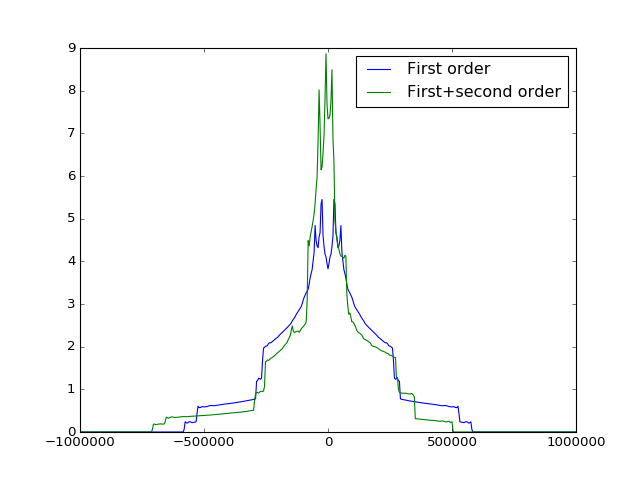

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(freqs, spec17O_1, label='First order')
ax.plot(freqs, spec17O_s, label='First+second order')

ax.legend()

In [15]:
# There's a number of other possible NMRFlags for various effects...
for fl in NMRFlags._fields:
    print fl

CS_ISO
CS_ORIENT
CS
Q_1_ORIENT
Q_2_SHIFT
Q_2_ORIENT_STATIC
Q_2_ORIENT_MAS
Q_2_STATIC
Q_2_MAS
Q_STATIC
Q_MAS
STATIC
MAS
